In [28]:
import Pkg; 

if split(pwd(),"/")[end] == "random_walk"
    cd(joinpath(@__DIR__, "../../../"))
    Pkg.activate("Project.toml")
end

using MorphoMol
using MorphoMolNotebooks
using CairoMakie
using LinearAlgebra
using Random
using Rotations
using StaticArrays
using Distributions
using Distances

In [31]:
mol_type = "1aly"
template_centers = MorphoMol.Utilities.TEMPLATES[mol_type]["template_centers"]
template_radii = MorphoMol.Utilities.TEMPLATES[mol_type]["template_radii"]
n_mol = 3
bounds = 100.0
x_init = MorphoMol.Utilities.get_initial_state(n_mol, bounds)
n_atoms_per_mol = length(template_radii)
radii = vcat([template_radii for i in 1:n_mol]...);

In [25]:
simulation_time_minutes = 60.0

T = 0.8
β = 1.0 / T

rs = 1.4
eta = 0.3665
pf = MorphoMol.Energies.get_prefactors(rs, eta)
overlap_slope = 1.1

σ_r = 0.25
σ_t = 1.25
Σ = vcat([[σ_r, σ_r, σ_r, σ_t, σ_t, σ_t] for _ in 1:n_mol]...)

energy(x) = solvation_free_energy_and_measures_in_bounds(x, template_centers, radii, rs, pf, 0.0, overlap_slope, bounds, 1.0)
perturbation(x) = perturb_single_randomly_chosen(x, σ_r, σ_t)

output = Dict{String, Vector}(
    "states" => Vector{Vector{Float64}}([]),
    "Es" => Vector{Float64}([]), 
    "Vs" => Vector{Float64}([]), 
    "As" => Vector{Float64}([]), 
    "Cs" => Vector{Float64}([]), 
    "Xs" => Vector{Float64}([]),
    "OLs" => Vector{Float64}([]),
    "αs" => Vector{Float32}([]),
)

rwm = MorphoMol.Algorithms.RandomWalkMetropolis(energy, perturbation, β)

MorphoMol.Algorithms.simulate!(rwm, x_init, simulation_time_minutes, output);
output["αs"][end]

0.0053994837f0

In [1]:
println("Initial energy: $(output["Es"][1]) | final energy: $(output["Es"][end]) | minimal energy: $(minimum(output["Es"]))")

LoadError: UndefVarError: `output` not defined

In [ ]:
calculate_T0(output["Es"], 10.0, 0.24)

10.0
1.3602967324652968
1.7068859024136136
1.592405555380175
1.6261558948447818
1.6157991670933745
1.618940596891625
1.6179843122179927
1.6182750999884536
1.618186647817253
1.6182135506030726


1.6182053678532284

In [27]:
try
    rm("assets/output", recursive = true)
catch 
end
mkpath("assets/output")
for (i, state) in enumerate(output["states"])
    MorphoMolNotebooks.configuration_to_poly(MorphoMol.Utilities.get_flat_realization(state, template_centers), radii, "assets/output/$(i)", n_mol, n_atoms_per_mol)
end

In [65]:
function generate_ouput_plots(sim_out)
    paired_colors = cgrad(:Paired_12, 12, categorical = true)
    xs = 1:length(sim_out["Vs"])

    pt_per_in = 72
    width =  5*5
    height = 5*3
    f_size = (pt_per_in * width, pt_per_in * height)
    fs = 15
    border_width = 0.5
    fig = Figure(size = f_size, fontsize = fs)
    ms = 4
    scatter(fig[1, 1], xs, sim_out["Vs"], markersize = ms, color = paired_colors[1], axis = (ylabel = L"V", ylabelrotation = 0,))
    scatter(fig[1, 2], xs, sim_out["As"], markersize = ms, color = paired_colors[3], axis = (ylabel = L"A", ylabelrotation = 0,))
    scatter(fig[1, 3], xs, sim_out["Cs"], markersize = ms, color = paired_colors[5], axis = (ylabel = L"C", ylabelrotation = 0,))
    scatter(fig[1, 4], xs, sim_out["Xs"], markersize = ms, color = paired_colors[7], axis = (ylabel = L"X", ylabelrotation = 0,))
    scatter(fig[2, 1], xs, sim_out["OLs"], markersize = ms, color = paired_colors[10], axis = (ylabel = L"OL", ylabelrotation = 0,))
    scatter(fig[2, 2], xs, sim_out["Es"], markersize = ms, color = paired_colors[12], axis = (ylabel = L"F_{sol}", ylabelrotation = 0,))
    #save(string("$(save_dir)/hmc_output_plots.png"), fig, pt_per_unit = 1)
    fig
end

generate_ouput_plots (generic function with 1 method)

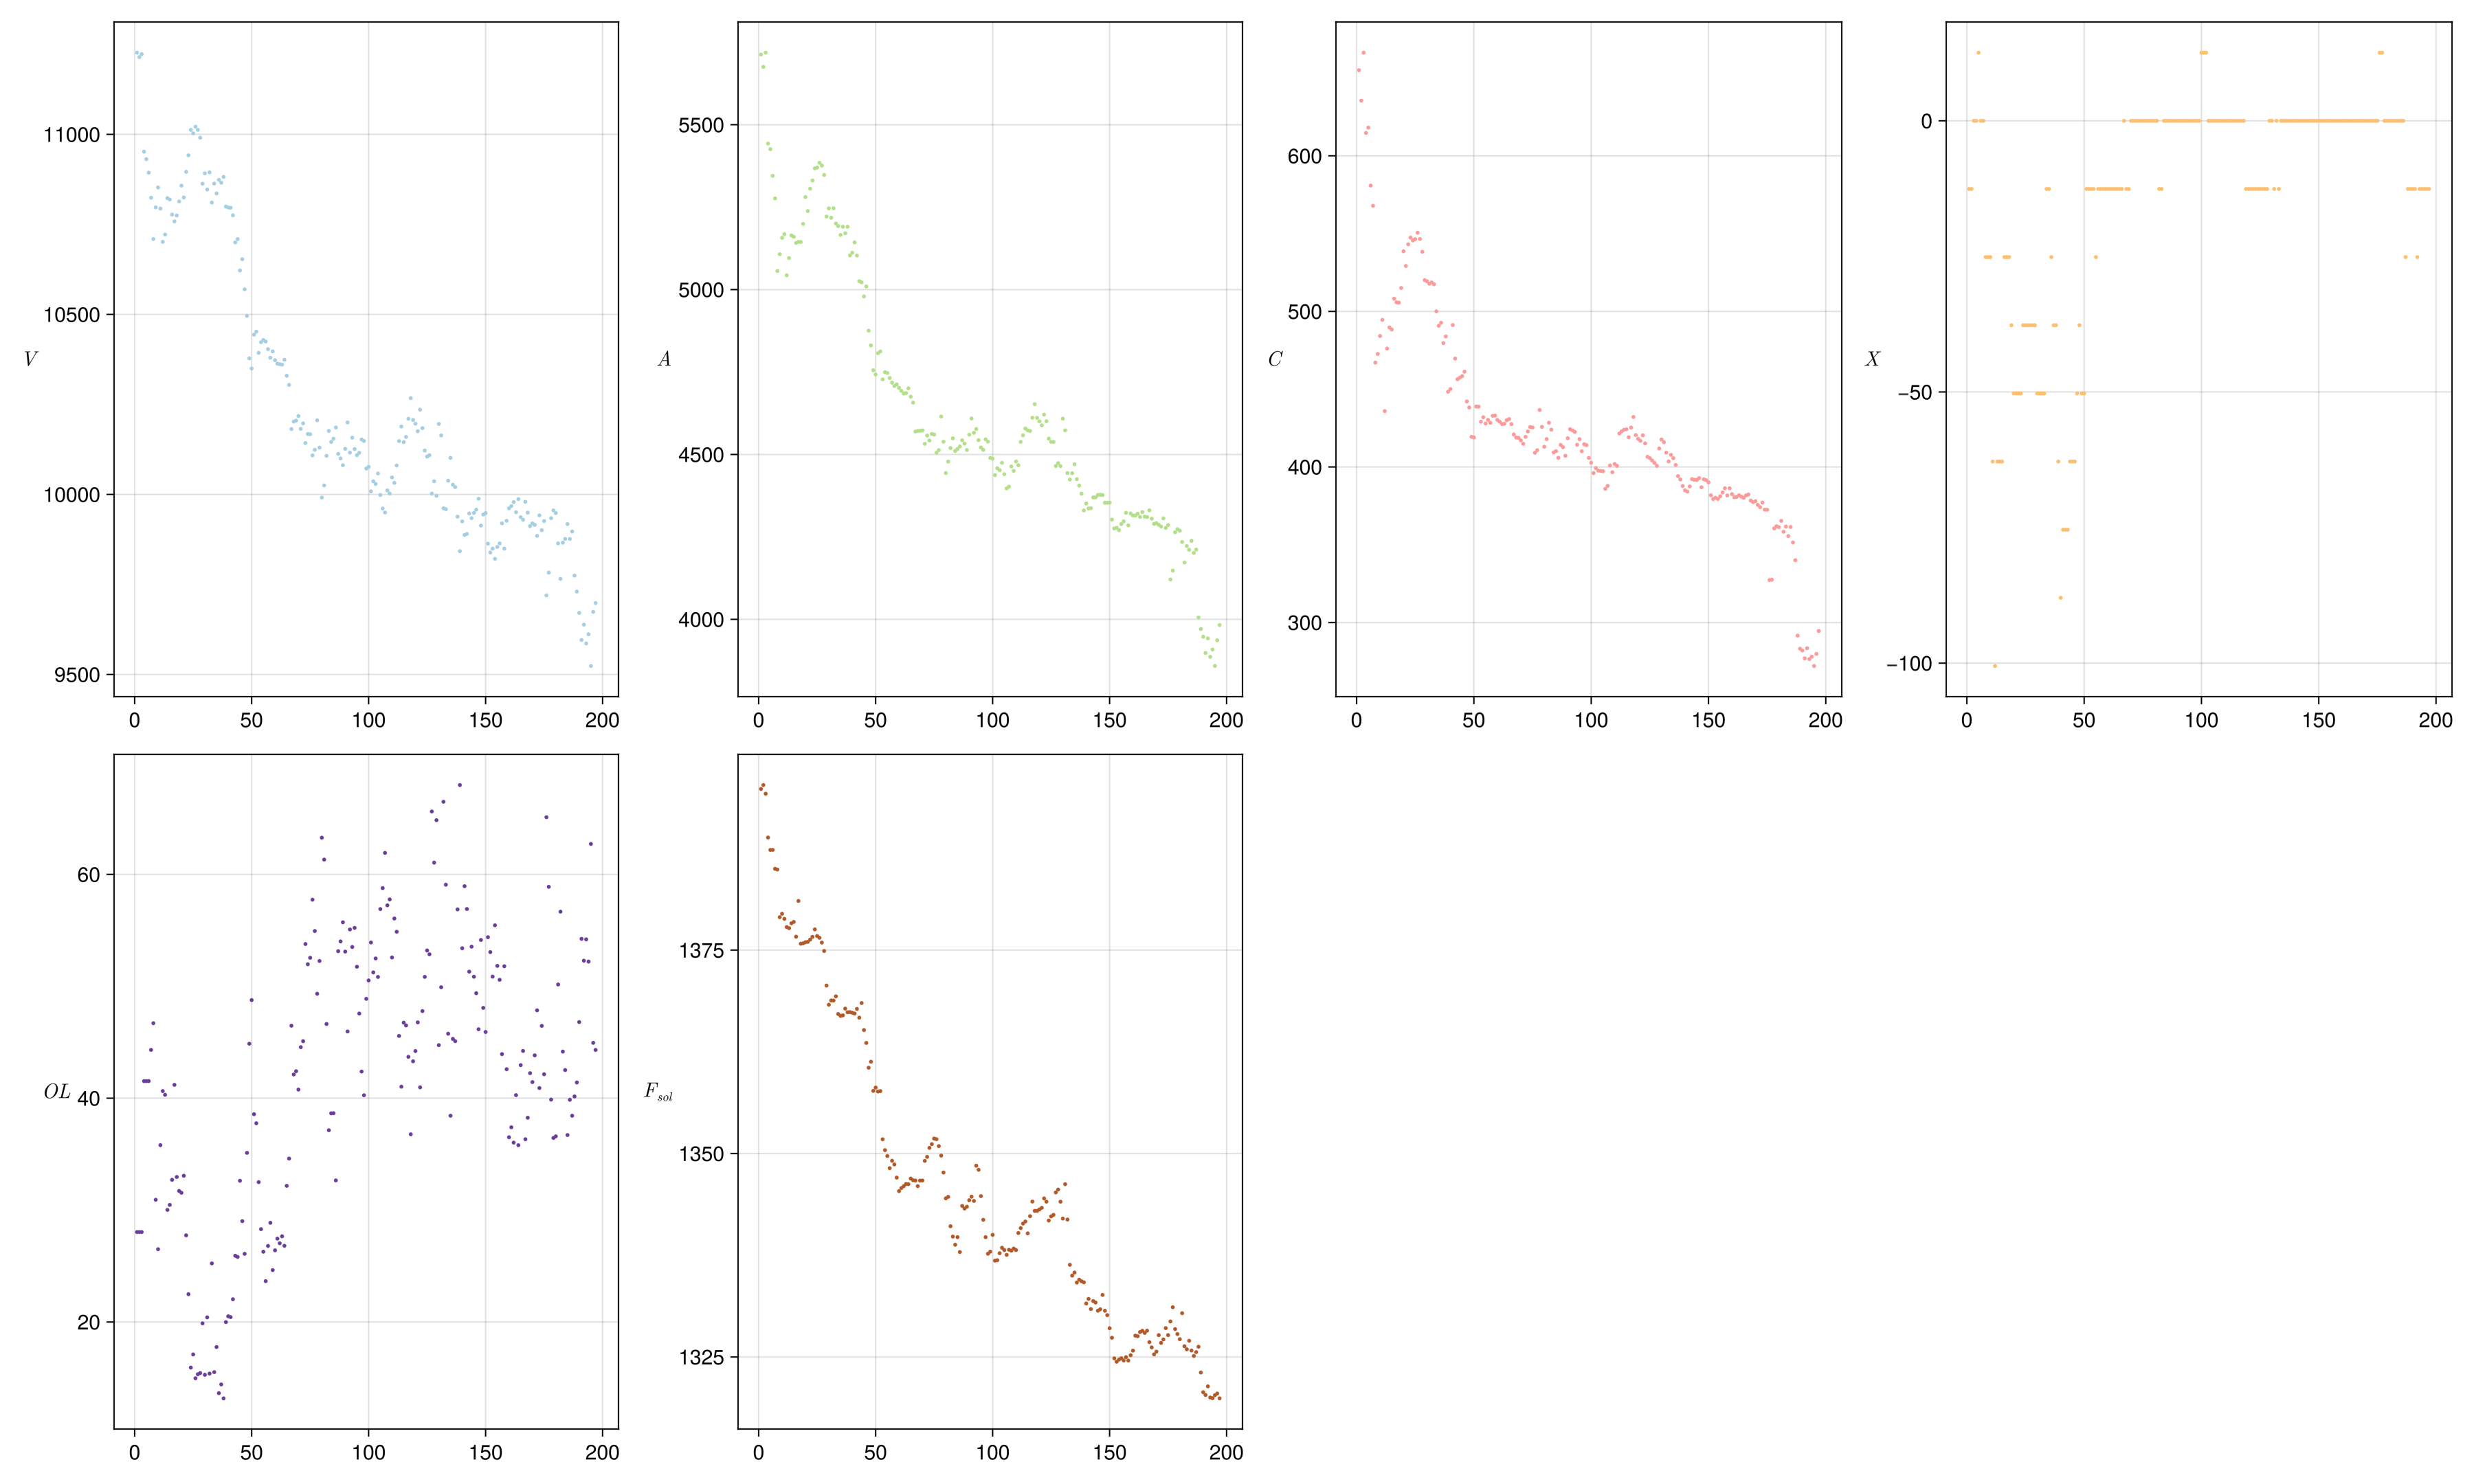

In [60]:
generate_ouput_plots(output)